# Bias in AI Systems 




## Why COMPAS?


Propublica started the COMPAS Debate with the article [Machine Bias](#References).  With their article, they also released details of their methodology and their [data and code](https://github.com/propublica/compas-analysis).  This presents a real data set that can be used for research on how data is used in a criminal justice settingn without researchers having to perform their own requests for information, so it has been used and reused a lot of times. 


<!--name:caseqs-->
## A COMPAS Case study

Next, let's look at what COMPAS is before we look at the data. 

The COMPAS score comes from the results of a [137 item survey](compas-core-sample.pdf).  It is distributed with a long [Practitioner's guide](compas_guide.pdf) that describes how it was developed and validated including which criminal theories it relies on. The claim is that COMPAS predicts two-year recidivism.  It has an accuracy around 67%.

### Discussion Questions

Breifly skim those and discuss things you find with your group. Make notes in the shared document about the following questions:

1. If the survey is administered through a social worker vs the defendent answering independently how might that impact responses?
1. How does knowing that the COMPAS score comes from that survey impact your view of it?  What problems might you predict? 
1. Who might this survey privelege?

<!--name:datainfo  -->
## Propublica COMPAS Data

The dataset consists of COMPAS scores assigned to defendants over two years 2013-2014 in Broward County, Florida. These scores are determined by a proprietary algorithm designed to evaluate a persons recidivism risk - the likelihood that they will reoffend. Risk scoring algorithms are widely used by judges to inform their scentencing and bail decisions in the criminal justice system in the United States. The original ProPublica analysis identified a number of fairness concerns around the use of COMPAS scores, including that ''black defendants were nearly twice as likely to be misclassified as higher risk compared to their white counterparts.'' Please see the full article for further details.



Let's get started by importing the libraries we will use.

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve
from utilities import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data prep

First we import the COMPAS dataset from the propublica repo and store it in a Pandas [dataframe](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html) object.

In [3]:
df = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv", 
                 header=0).set_index('id')


In [33]:
df.to_csv('compas.csv')

First, let's take a look at this dataset. We print the features, and then the first entries.

In [4]:
print(list(df))
df.head()

['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Data Cleaning

For this analysis, we will restrict ourselves to only a few features, and clean the dataset according to the methods using in the original ProPublica analysis. 

Details of the cleaning method can be found in the utilities file.

In [5]:
# Select features that will be analyzed
features_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
df = df[features_to_keep]
df = clean_compas(df)
df.head()
print("\ndataset shape (rows, columns)", df.shape)

Number of rows removed: 1042
Features: ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay']

dataset shape (rows, columns) (6172, 14)


In [32]:
df.to_csv('compas_clean.csv')

## Data Exploration

Next we provide a few ways to look at the relationships between the attributes in the dataset. Here is an explanation of these values:

* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10 (low risk to high risk)
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

In particular, as in the ProPublica analysis, we are interested in the implications for the treatment of different groups as defined by some **sensitive data attributes**. In particular we will consider race as the protected attribute in our analysis. Next we look at the number of entries for each race.


<font color=red> Another interesting fairness analysis might be to consider group outcomes by gender or age. In fact, a [2017 appeal to the US Suprme Court](https://en.wikipedia.org/wiki/Loomis_v._Wisconsin) challenged the role of gender in determining COMPAS scores.</font> 

In [8]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

We restrict our analysis to African-American and Caucasian, since we have significantly more samples for these two groups. We remove entries not marked as African-American or Caucasian, and look at the distribution of COMPAS scores.

In [9]:
df = df.loc[df['race'].isin(['African-American','Caucasian'])]

### COMPAS score distribution

Let's look at the COMPAS score distribution between African-Americans and Caucasians (matches the one in the ProPublica article).

In [18]:
race_score_table = df.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)

# percentage of defendants in each score category
(100*race_score_table/race_score_table.sum()).transpose()

decile_score,1,2,3,4,5,6,7,8,9,10
race,,,,,,,,,,
African-American,11.496063,10.897638,9.385827,10.614173,10.173228,10.015748,10.803150,9.480315,9.984252,7.149606
Caucasian,28.768426,15.263909,11.317166,11.554922,9.510223,7.608179,5.373276,4.564907,3.661436,2.377556


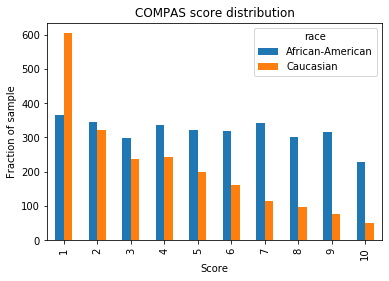

In [24]:
race_score_table.plot(kind='bar')
plt.title('COMPAS score distribution')
plt.xlabel('Score')
plt.ylabel('Fraction of sample');

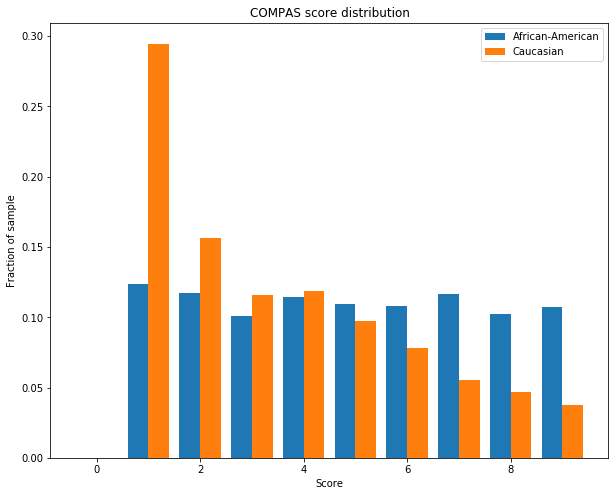

In [11]:
# now in visual form
x = df.loc[df['race']=='African-American','decile_score'].values
y = df.loc[df['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[10,8])
plt.hist([x,y],normed=True,bins = np.arange(-.5,10.5,1))
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution')
plt.xlabel('Score')
plt.ylabel('Fraction of sample');

As you can observe, there is a large discrepancy. Does this change when we condition on other random variables? We'll start with priors and look at how those are distributed

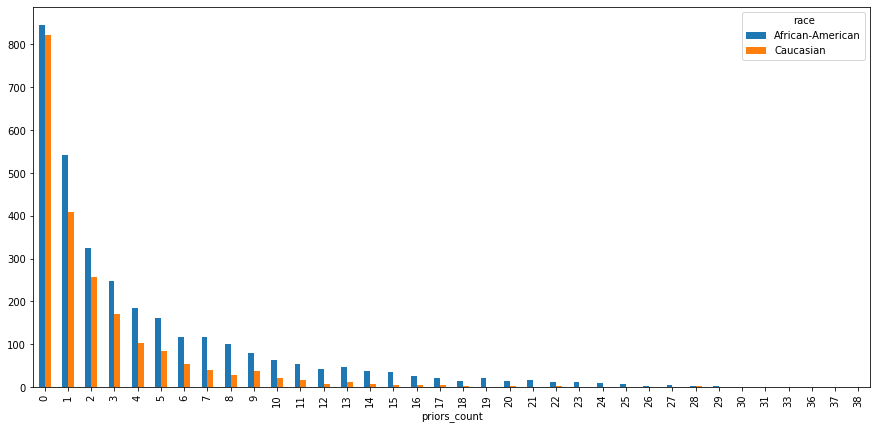

In [29]:
priors = df.groupby(['race','priors_count']).size().reset_index().pivot(index='priors_count',columns='race',values=0)
priors.plot(kind='bar',figsize=[15,7])

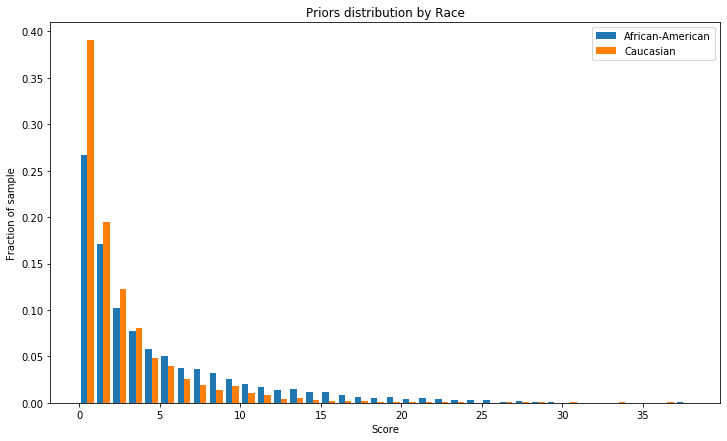

In [12]:

x = df.loc[df['race']=='African-American','priors_count'].values
y = df.loc[df['race']=='Caucasian','priors_count'].values
plt.figure(figsize=[12,7])

plt.hist([x,y],normed=True,bins = max(np.unique(np.concatenate((x,y)))))
plt.legend(['African-American','Caucasian'])
plt.title('Priors distribution by Race')
plt.xlabel('Score')
plt.ylabel('Fraction of sample');

Let's look at the distribution of scores for individuals with more than 2 priors.

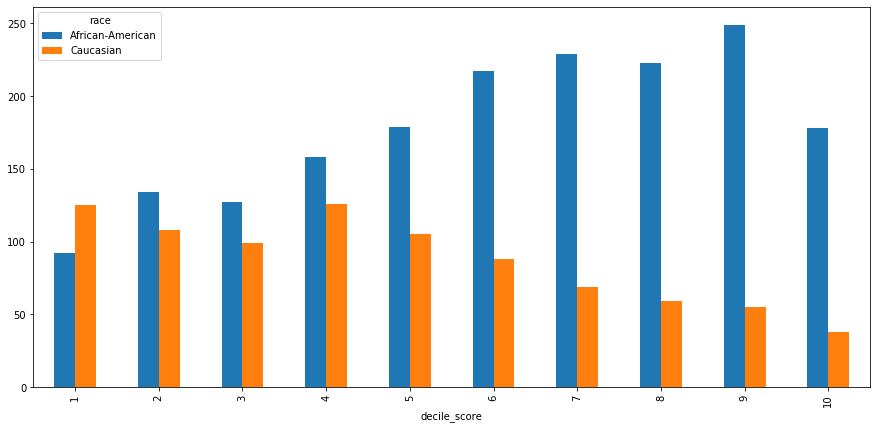

In [30]:
df_2priors = df.loc[df['priors_count']>=2]
score_2priors = df_2priors.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)
score_2priors.plot(kind='bar',figsize=[15,7])

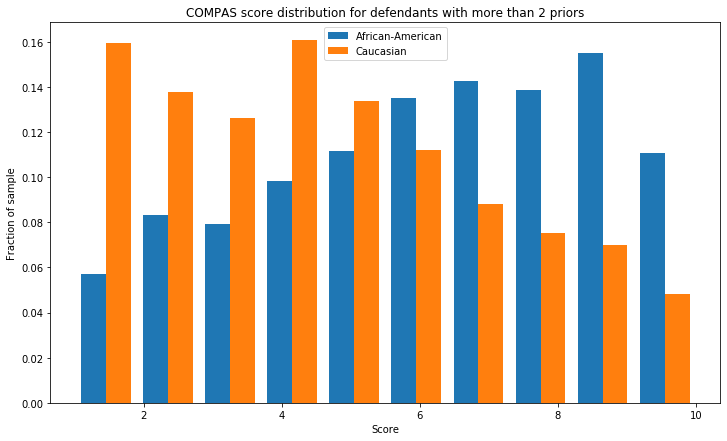

In [13]:
df_2priors = df.loc[df['priors_count']>=2]
x = df_2priors.loc[df_2priors['race']=='African-American','decile_score'].values
y = df_2priors.loc[df_2priors['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution for defendants with more than 2 priors')
plt.xlabel('Score')
plt.ylabel('Fraction of sample');

Still a big difference. What about those with less than two priors?

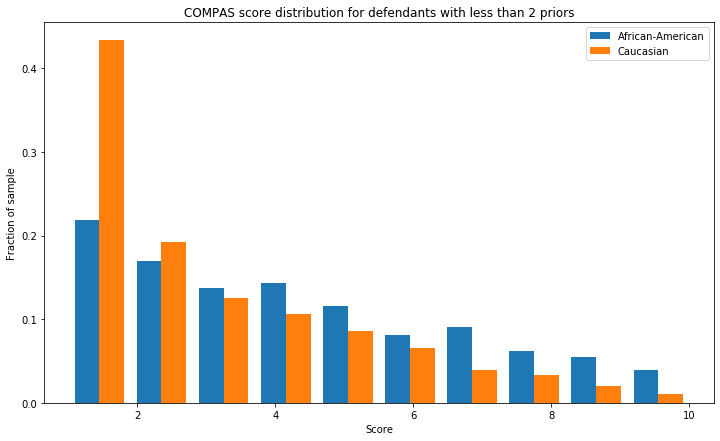

In [14]:
df_2priors = df.loc[df['priors_count']<2]
x = df_2priors.loc[df_2priors['race']=='African-American','decile_score'].values
y = df_2priors.loc[df_2priors['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution for defendants with less than 2 priors')
plt.xlabel('Score')
plt.ylabel('Fraction of sample');


### Question: ###
How does the COMPAS score distribution change under different conditionings (e.g. degree charged, length of prison stay, etc.)? Does a [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox)-like phenomenom happen?

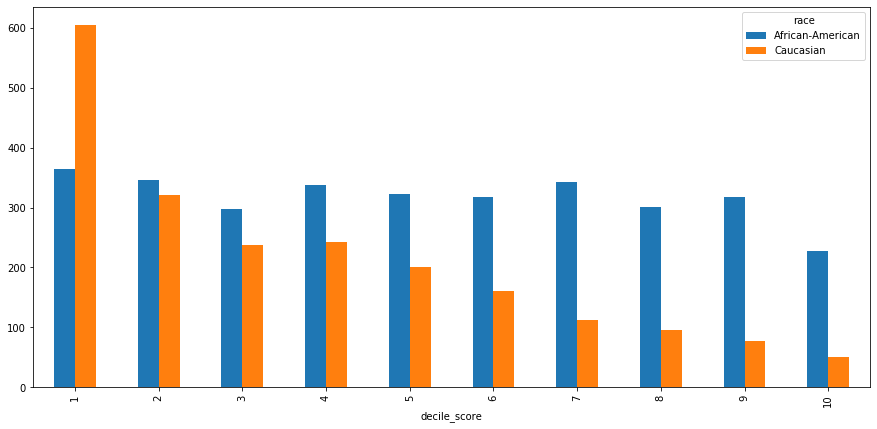

In [31]:
# hard to find... For example at young felons with no priors
df_ans = df.loc[(df['priors_count']==0)&(df['c_charge_degree']=='F')&df['age']<=25]
score_ans = df_ans.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)
score_ans.plot(kind='bar',figsize=[15,7])

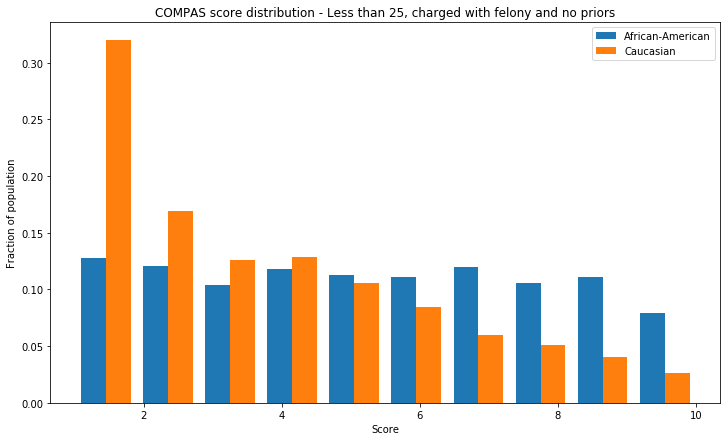

In [15]:

x = df_ans.loc[df_ans['race']=='African-American','decile_score'].values
y = df_ans.loc[df_ans['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Less than 25, charged with felony and no priors')
plt.xlabel('Score')
plt.ylabel('Fraction of population');

We quantize our dataset next to make the analysis a little bit easier.

In [16]:
dfQ = df.copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'

    
# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'
    
# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 1
    else:
        return 0

    
dfQ['priors_count'] = dfQ['priors_count'].apply(quantizePrior)
dfQ['length_of_stay'] = dfQ['length_of_stay'].apply(quantizeLOS)
dfQ['score_text'] = dfQ['score_text'].apply(quantizeScore)
dfQ['age_cat'] = dfQ['age_cat'].apply(adjustAge)

In [17]:
dfQ.to_csv('compas_cleanQ.csv')

Now we can look at the percentage difference of the average COMPAS scores between Caucasians and African-Americans for different groups. (**Important**: error bars omitted, so large differences may be due to limited samples)

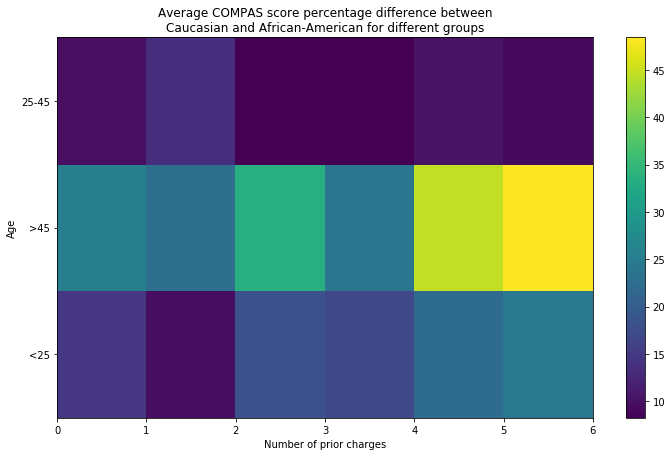

In [14]:
# African-american
dfPlot_AA = dfQ.loc[dfQ['race']=='African-American'].copy()
dfPlot_AA = dfPlot_AA.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_AA = dfPlot_AA.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

# Caucasian
dfPlot_C = dfQ.loc[dfQ['race']=='Caucasian'].copy()
dfPlot_C = dfPlot_C.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_C = dfPlot_C.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

plt.figure(figsize=[12,7])
# sns.heatmap(100*(dfinal_AA.div(dfinal_C)-1),cmap="coolwarm",annot=True)
f = 100*(dfinal_AA.div(dfinal_C)-1)
plt.pcolor(f)
plt.colorbar()
plt.yticks([0.5,1.5,2.5],['<25', '>45', '25-45'])
# plt.yticklabels(
plt.ylabel("Age")
plt.xlabel("Number of prior charges")
plt.title('Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')
plt.show()

What's happening with the "greater than 45" group? Let's plot the score distribution for that group.

Text(0, 0.5, 'Fraction of population')

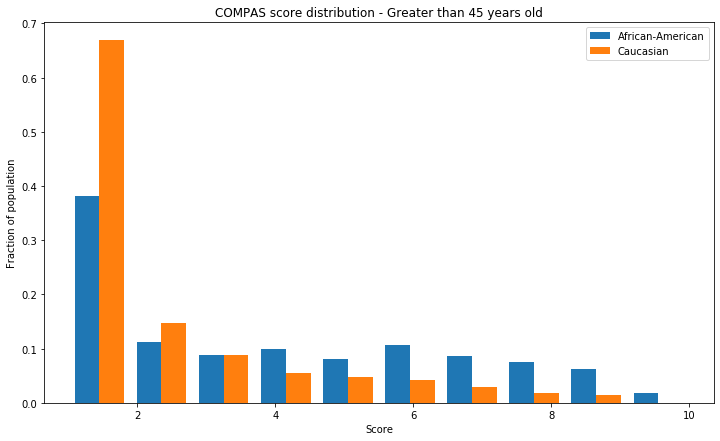

In [15]:
df_g45 = df.loc[(df['age']>=45)]
x = df_g45.loc[df_g45['race']=='African-American','decile_score'].values
y = df_g45.loc[df_g45['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Greater than 45 years old')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

## What happens when we take actual 2-year recidivism values into account? Are the predictions fair?

First, let's look at the correlation between the quantized score, the decile score and the actual recidivism.

In [16]:
# Correlation between COMPAS score and 2-year recidivism

# measure with high-low score
print(dfQ[['two_year_recid','score_text']].corr())

# measure with decile_score
print(dfQ[['two_year_recid','decile_score']].corr())

                two_year_recid  score_text
two_year_recid        1.000000    0.314698
score_text            0.314698    1.000000
                two_year_recid  decile_score
two_year_recid        1.000000      0.368193
decile_score          0.368193      1.000000


The correlation is not that high. How can we evaluate whether the predictions made by the COMPAS scores are fair, especially considering that they do not predict recidivism rates well?

##  Fairness Metrics

The question of how to determine if an algorithm is *fair* has seen much debate recently (see this tutorial from the Conference on Fairness, Acountability, and Transparency titled [21 Fairness Definitions and Their Politics](https://fatconference.org/2018/livestream_vh220.html).

And in fact some of the definitions are contradictory, and have been shown to be mutually exclusive [2,3] https://www.propublica.org/article/bias-in-criminal-risk-scores-is-mathematically-inevitable-researchers-say

Here we will cover 3 notions of fairness and present ways to measure them:

1. **Disparate Impact** [4](#References) 
[The 80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule)

2. **Calibration** [6](#References)

4. **Equalized Odds** [5](#References) 

For the rest of our analysis we will use a binary outcome - COMPAS score <= 4 is LOW RISK, >4 is HIGH RISK.

### Disparate Impact

Disparate impact is a legal concept used to describe situations when an entity such as an employer *inadvertently* discriminates gainst a certain protected group. This is distinct from *disparate treatment* where discrimination is intentional. 

To demonstrate cases of disparate impact, the Equal Opportunity Commission (EEOC) proposed "rule of thumb" is known as the [The 80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule). 

Feldman et al. [4](#References) adapted a fairness metric from this  principle. For our application, it states that the percent of defendants predicted to be high risk in each protected group (in this case whites and african-americans) should be within 80% of each other. 

Let's evaluate this standard for the COMPAS data.

In [17]:
#  Let's measure the disparate impact according to the EEOC rule
means_score = dfQ.groupby(['score_text','race']).size().unstack().reset_index()
means_score = means_score/means_score.sum()
means_score

race,score_text,African-American,Caucasian
0,0.0,0.423937,0.669044
1,1.0,0.576063,0.330956


In [18]:
# compute disparte impact
AA_with_high_score = means_score.loc[1,'African-American']
C_with_high_score = means_score.loc[1,'Caucasian']

C_with_high_score/AA_with_high_score

0.5745131730114521

This ratio is below .8, so there is disparate impact by this rule.  (Taking the priveleged group and the undesirable outcome instead of the disadvantaged group and the favorable outcome).

What if we apply the same rule to the **true** two year recidivism instead of the quantized COMPAS score?

In [19]:
means_2yr = dfQ.groupby(['two_year_recid','race']).size().unstack()
means_2yr = means_2yr/means_2yr.sum()
means_2yr

race,African-American,Caucasian
two_year_recid,,
0,0.47685,0.60913
1,0.52315,0.39087


In [20]:
# compute disparte impact
AA_with_high_score = means_2yr.loc[1,'African-American']
C_with_high_score = means_2yr.loc[1,'Caucasian']
C_with_high_score/AA_with_high_score

0.7471480065031378

There is a difference in re-arrest, but not as high as assigned by the COMPAS scores. This is still a disparate impact of the actual arrests (since this not necesarrily accurate as a recidivism rate, but it is true rearrest).

Now let's measure the difference in scores when we consider both the COMPAS output and true recidivism.

### Calibration 

A discussion of using calibration to verify the fairness of a model can be found in Northpoint's response to the ProPublica article [6](#References). 

The basic idea behind calibrating a classifier is that you want the confidence of the predictor to reflect the true outcomes. So, in a well-calibrated classifier, if 100 people are assigned 90% confidence of being in the positive class, then in reality, 90 of them should actually have had a positive label. 

To use calibration as a fairness metric we compare the calibration of the classifier for each group.  The smaller the difference, the more fair the calssifier.

In our problem this can be expressed as given $Y$ indicating two year recidivism, $S_Q$ indicating score (0=low, 1=high medium), and $R$ indicating race, we measure

$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ for different scores $s$. Considering our quantized scores, we look at the calibration for $s=1$. 

In [21]:
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()
dfAverage

score_text,0,1
race,,
African-American,0.351412,0.649535
Caucasian,0.289979,0.594828


In [22]:
num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

Calibration: 1.091972
Calibration in percentage: 9.197233%


The difference looks much smaller than before. The problem of the above calibration measure is that it depends on the threshold on which we quantized the scores $S_Q$. 

In order to mitigate this, ine might use a variation of this measure called *predictive parity.* In this example, we define predictive parity as

$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

We plot $\mathsf{PP}(s) $ for $s$ from 1 to 10. Note how predictive parity depends significantly on the threshold.

Text(0.5, 1.0, 'Predictive parity for different thresholds\n(warning: no error bars)')

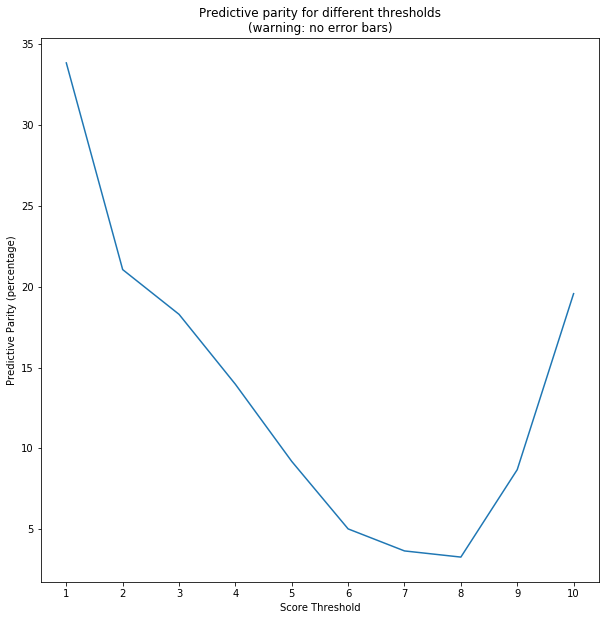

In [23]:
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

### Equalized Odds

The last fairness metric we consider is based on the difference in *error rates* between groups. Hardt et al. [5](#References) propose to look at the difference in the true positive and false positive rates for each group. This aligns with the analysis performed by Propublica. WE can examine these values looking at is the ROC for each group. We normalize the score between 0 and 1. The ROC thresholds produced by `scikitlearn` are the same.

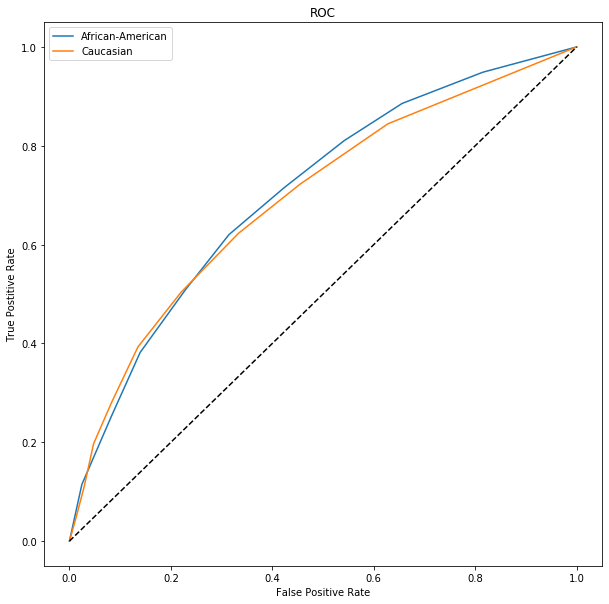

In [24]:
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])


For each group, the point in the ROC curve corresponds to a $$(\mbox{false postive rate, true positive rate})$$ pair for a given threshold. In order to caputre the difference in error rates, we map the points to $$\left(\frac{\mbox{false postive rate Afr.-American}}{\mbox{false postive rate Cauc.}},s \right)$$
and similarly for *false negative* rates for different thersholds s.

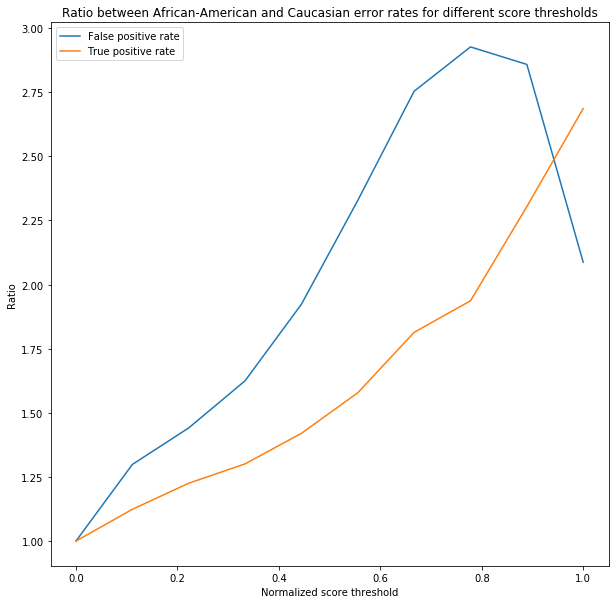

In [25]:
fpr_ratio = fpr1[1:]/fpr2[1:]
tpr_ratio = (tpr1[1:])/(tpr2[1:])
plt.figure(figsize=[10,10])
plt.plot(thresh1[1:],fpr_ratio)
plt.plot(thresh1[1:],tpr_ratio)
plt.xlabel('Normalized score threshold')
plt.ylabel('Ratio')

plt.legend(['False positive rate','True positive rate'])
plt.title('Ratio between African-American and Caucasian error rates for different score thresholds');

The difference is once again stark. This graph is particlarly concerning due to the significantly higher false positive rates for African Americans across all thresholds.

# Corels

COPMAS has also been critcized for being a generally opaque system. 

We saw during the interpretability class, the [CORELS system](https://corels.eecs.harvard.edu/corels/run.html). It learns a rule list from the Propulica data and reports similar accuracy. 

```
if ({Prior-Crimes>3}) then ({label=1})
else if ({Age=18-22}) then ({label=1})
else ({label=0})
```

Let's investigate how that score compares

In [26]:
def corels_rule(row):
    return int(row['priors_count'] > 3 or (row['priors_count'] <=3 and row['age'] <=22))

In [27]:
df['corels'] = df.apply(corels_rule,axis=1)

In [28]:
#  Let's measure the disparate impact according to the EEOC rule
means_corel = df.groupby(['corels','race']).size().unstack().reset_index()
means_corel = means_corel/means_corel.sum()
means_corel

race,corels,African-American,Caucasian
0,0.0,0.48315,0.701854
1,1.0,0.51685,0.298146


In [29]:
# compute disparte impact
AA_with_high_score = means_corel.loc[1,'African-American']
C_with_high_score = means_corel.loc[1,'Caucasian']

C_with_high_score/AA_with_high_score

0.5768506903605104

What conclusions can you draw about this simple algorithm?  Is its behavior expected or surprising?

### Linear Predictor

_if time or for later_

One part of the Dressel result was that a linear predictor in the available features as released by Propublica can also acheive similar accuracy.  Try to repeat that analysis.

## References

[1]ProPublica, *“Machine Bias,”* https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing, May 2016.

[] ProPublica  https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

[2] A. Chouldechova. *"Fair prediction with disparate impact: A study of bias in recidivism prediction instruments."* arXiv preprint arXiv:1703.00056 (2017).

[3](#3) Kleinberg, Jon, Sendhil Mullainathan, and Manish Raghavan. "Inherent trade-offs in the fair determination of risk scores." arXiv preprint arXiv:1609.05807 (2016).

[4] Feldman, Michael, Sorelle A. Friedler, John Moeller, Carlos Scheidegger, and Suresh Venkatasubramanian. *"Certifying and removing disparate impact."* In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 259-268. ACM, 2015.

[5] Hardt, Moritz, Eric Price, and Nati Srebro. *"Equality of opportunity in supervised learning."* Advances in neural information processing systems. 2016.

[6] Dieterich, William, Christina Mendoza, and Tim Brennan. "COMPAS risk scales: Demonstrating accuracy equity and predictive parity." Northpoint Inc (2016).